In [2]:
import bokeh
from bokeh.io import output_notebook
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import torch
from natsort import natsorted

from util.py_util import timed_print
from util import subprocess_util

torch.set_printoptions(linewidth=120, edgeitems=5)
output_notebook()

Loading BokehJS ...

In [47]:
blank_arr = torch.zeros((1,2,7,6))
blank_arr[(0, 0, 0, 0)] = 1
blank_arr[(0, 0, 0, 1)] = 1
blank_arr[(0, 0, 0, 2)] = 1
blank_arr[(0, 1, 4, 0)] = 1
blank_arr[(0, 1, 4, 1)] = 1
blank_arr[(0, 1, 4, 2)] = 1
 
special_arr = torch.zeros((1,2,7,6))
special_arr[(0, 1, 3, 0)] = 1
special_arr[(0, 0, 4, 0)] = 1
special_arr[(0, 1, 4, 1)] = 1

special_arr2 = torch.zeros((1,2,7,6))
special_arr2[(0, 0, 3, 0)] = 1
special_arr2[(0, 1, 2, 0)] = 1

RY_middle_arr = torch.zeros((1,2,7,6))
RY_middle_arr[(0, 0, 3, 0)] = 1
RY_middle_arr[(0, 1, 4, 0)] = 1
# RY_middle_arr[(0, 0, 0, 0)] = 1

In [42]:
class Summarizer:
    def __init__(self, models_dir: str):
        self.x_dict = {}
        self.y1_dict = {}
        self.y2_dict = {}
        self.models_dir = models_dir
    
    def reload(self):
        x = []
        y1 = []
        y2 = []
        for filename in natsorted(os.listdir(self.models_dir)):
            if not filename.startswith('gen'): continue
            if not filename.endswith('.ptj'): continue
            gen = int(filename[3:].split('.')[0])
            if gen in self.x_dict:
                x.append(self.x_dict[gen])
                y1.append(self.y1_dict[gen])
                y2.append(self.y2_dict[gen])
                continue
            full_filename = os.path.join(self.models_dir, filename)
            model = torch.jit.load(full_filename)

            xx = gen
            yy1 = model(blank_arr)[0].softmax(dim=1)[0][3]
            yy2 = model(RY_middle_arr)[0].softmax(dim=1)[0][3]

            self.x_dict[gen] = xx
            self.y1_dict[gen] = yy1
            self.y2_dict[gen] = yy2
            x.append(xx)
            y1.append(yy1)
            y2.append(yy2)
    
        plt.plot(x, y1, label='Blank board')
        plt.plot(x, y2, label='After 2 middle moves')
        plt.title(f'Policy probability of playing in middle ({len(x)} gens)')
        plt.legend()
        plt.xlabel('Generation')
        plt.ylabel('Probability')
        plt.show()

In [62]:
def load(games_dirs):
    n_games = 0
    move3_count = 0
    good_rows = 0
    total_rows = 0
    draw_count = 0
    R_win_count = 0
    Y_win_count = 0
    special_count = 0
    full_value_RY_mid_list = []
    full_value_blank_list = []
    full_policy_RY_mid_list = []
    full_policy_blank_list = []
    
    for games_dir in games_dirs:
        for filename in os.listdir(games_dir):
            if filename == 'done.txt':
                continue
                
            n_games += 1
            full_filename = os.path.join(games_dir, filename)
            datak = torch.jit.load(full_filename).state_dict()
            inputk = datak['input']
            valuek = datak['value']
            policyk = datak['policy']

            total_rows += len(valuek)

            for v in valuek:
                if v[0]==1:
                    R_win_count += 1
                elif v[1]==1:
                    Y_win_count += 1
                else:
                    assert v[0]==0.5 and v[1]==0.5, v
                    draw_count += 1
            
            special = False
            move3 = False
            for t in inputk:
#                 if bool((t==special_arr).all()) or bool((t==special_arr2).all()):
                if bool((t==special_arr2).all()):
                    special = True
                f = int(t.sum())
                if f == 3:
                    move3 = True
                if f == 4:
                    if t[(0, 3, 0)] and t[(1, 4, 0)] and t[(0, 0, 0)]:
                        good_rows += 1

            if special:
                special_count += 1
            if move3:
                move3_count += 1
                
            j_list = [j for (j, t) in enumerate(inputk) if bool((t == RY_middle_arr).all())]
            full_value_RY_mid_list.append(valuek[j_list])
            full_policy_RY_mid_list.append(policyk[j_list])

            j_list = [j for (j, t) in enumerate(inputk) if bool((t == blank_arr).all())]
            full_value_blank_list.append(valuek[j_list])
            full_policy_blank_list.append(policyk[j_list])
        
    full_value_RY_mid = torch.concat(full_value_RY_mid_list)
    full_value_blank = torch.concat(full_value_blank_list)
    full_policy_RY_mid = torch.concat(full_policy_RY_mid_list)
    full_policy_blank = torch.concat(full_policy_blank_list)
#     print(f'Loaded {games_dir}!')
    print(f'Total rows: {total_rows}')
    print('Move3: %s/%s (%.2f%%)' % (move3_count, n_games, move3_count * 100. / n_games))
    print('Special rows: %s/%s (%.2f%%)' % (special_count, n_games, special_count * 100. / n_games))
    print(f'Good rows: {good_rows}')
    print(f'Draw count: {draw_count}')
    print(f'R win count: {R_win_count}')
    print(f'Y win count: {Y_win_count}')
    print('num rows with RY middle:', len(full_value_RY_mid))
    print('num rows with blank:', len(full_value_blank))
    RY_value_avg = list(map(float, full_value_RY_mid.sum(dim=0) / len(full_value_RY_mid)))
    blank_value_avg = list(map(float, full_value_blank.sum(dim=0) / len(full_value_blank)))
    print(f'RY_value_avg: {RY_value_avg}')
    print(f'blank_value_avg: {blank_value_avg}')

    RY_policy_avg = list(map(float, full_policy_RY_mid.sum(dim=0) / len(full_policy_RY_mid)))
    blank_policy_avg = list(map(float, full_policy_blank.sum(dim=0) / len(full_policy_blank)))
    print(f'RY_policy_avg: {RY_policy_avg}')
    print(f'blank_policy_avg: {blank_policy_avg}')


In [63]:
load(['/media/dshin/c4h/self-play-data/gen-%d' % gen for gen in range(220, 240)])

Total rows: 626608
Move3: 7765/31452 (24.69%)
Special rows: 7576/31452 (24.09%)
Good rows: 53
Draw count: 529054
R win count: 41194
Y win count: 56360
num rows with RY middle: 7576
num rows with blank: 0
RY_value_avg: [0.48944035172462463, 0.5105596780776978]
blank_value_avg: [nan, nan]
RY_policy_avg: [0.0654279887676239, 0.06066833809018135, 0.05031409114599228, 0.037269316613674164, 0.7108511328697205, 0.03044154681265354, 0.04502759128808975]
blank_policy_avg: [nan, nan, nan, nan, nan, nan, nan]


In [39]:
summarizer = Summarizer('/media/dshin/c4/models')

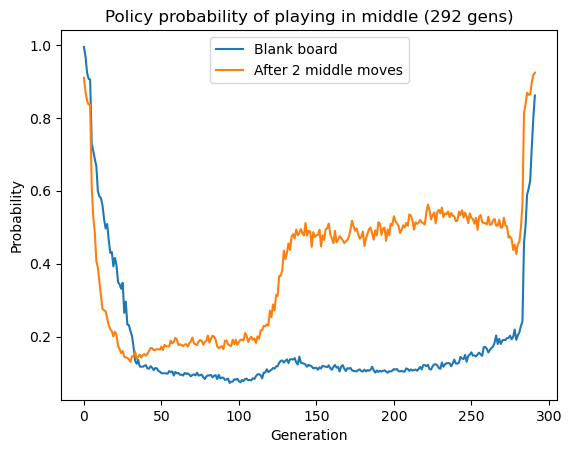

In [156]:
summarizer.reload()

In [235]:
summarizer2 = Summarizer('/media/dshin/c4d/models')

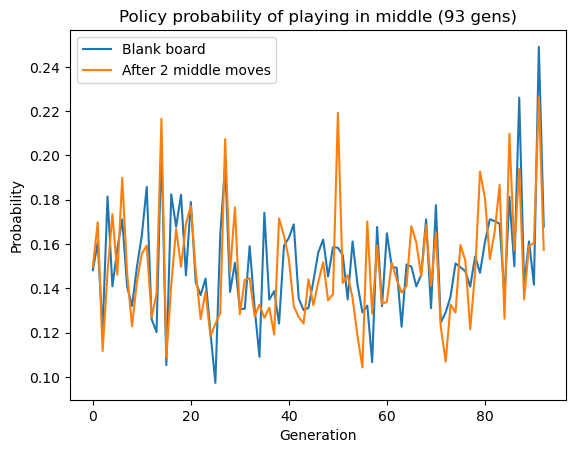

In [259]:
summarizer2.reload()

In [218]:
class Stats:
    def __init__(self, correct=0, total=0):
        self.correct = correct
        self.total = total

        
class Grader:
    def __init__(self, model_path):
        cmd = ['target/Release/bin/c4_competitive_self_play', 
               '--nnet-filename', model_path,
               '-i', '300',
               '-t', '0.2',
               '-G', '200',
               '--grade-moves', '--hide-progress-bar'
              ]
        print(f'Running: {" ".join(cmd)}')
        proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, encoding='utf-8')
        stdout = proc.communicate()[0]
        print('Run complete!')
        lines = stdout.splitlines()
        self.results = {}  # (player, move) -> Stats
        for line in lines:
            if not line.startswith('PerfectGrader '):
                continue
            # PerfectGrader player=0 move=-42 correct=190 total=190
            tokens = line.split()
            d = {k:int(v) for k, v in [t.split('=') for t in tokens[1:]]}
            player = d['player']
            move = d['move']
            correct = d['correct']
            total = d['total']
            
            self.results[(player, move)] = Stats(correct, total)

    def plot(self, move):
        key = (-1, move)
        stats = self.results[key]
        print(f'move={move} correct={stats.correct} total={stats.total}')

        
class MasterGrader:
    def __init__(self, models_dir):
        self.models_dir = models_dir
        self.graders = {}  # gen -> Grader
    
    def reload(self):
        for filename in os.listdir(self.models_dir):
            assert filename.startswith('gen'), filename
            gen = int(filename.split('.')[0][3:])
            if gen in self.graders:
                continue
            self.graders[gen] = Grader(os.path.join(self.models_dir, filename))

    def plot(self, move):
        x = []
        y = []
        key = (-1, move)
        for gen in sorted(self.graders):
            grader = self.graders[gen]
            stats = grader.results.get(key, None)
            if stats is None:
                continue
            pct = stats.correct * 1.0 / stats.total
            x.append(gen)
            y.append(pct)
            
        plt.plot(x, y)
        plt.title(f'Correct move frequency (move:{move})')
        plt.xlabel('Generation')
        plt.ylabel('Probability')
        plt.show()

In [242]:
grader = MasterGrader('/media/dshin/c4d/models')

In [243]:
grader.reload()

Running: target/Release/bin/c4_competitive_self_play --nnet-filename /media/dshin/c4d/models/gen13.ptj -i 300 -t 0.2 -G 200 --grade-moves --hide-progress-bar
Run complete!
Running: target/Release/bin/c4_competitive_self_play --nnet-filename /media/dshin/c4d/models/gen12.ptj -i 300 -t 0.2 -G 200 --grade-moves --hide-progress-bar
Run complete!
Running: target/Release/bin/c4_competitive_self_play --nnet-filename /media/dshin/c4d/models/gen8.ptj -i 300 -t 0.2 -G 200 --grade-moves --hide-progress-bar
Run complete!
Running: target/Release/bin/c4_competitive_self_play --nnet-filename /media/dshin/c4d/models/gen10.ptj -i 300 -t 0.2 -G 200 --grade-moves --hide-progress-bar
Run complete!
Running: target/Release/bin/c4_competitive_self_play --nnet-filename /media/dshin/c4d/models/gen4.ptj -i 300 -t 0.2 -G 200 --grade-moves --hide-progress-bar
Run complete!
Running: target/Release/bin/c4_competitive_self_play --nnet-filename /media/dshin/c4d/models/gen3.ptj -i 300 -t 0.2 -G 200 --grade-moves --hid

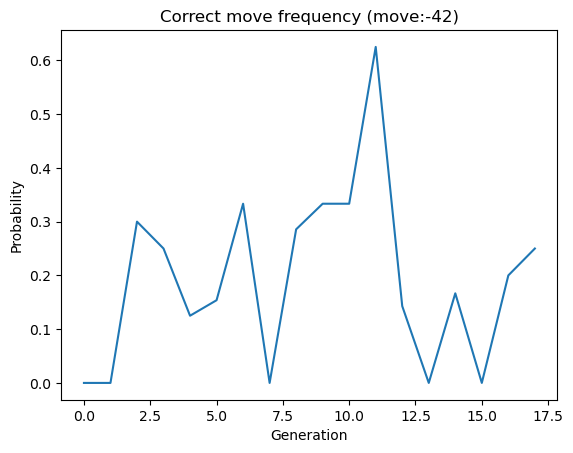

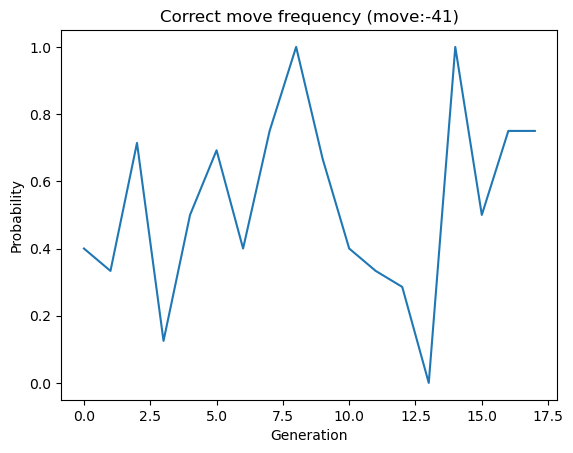

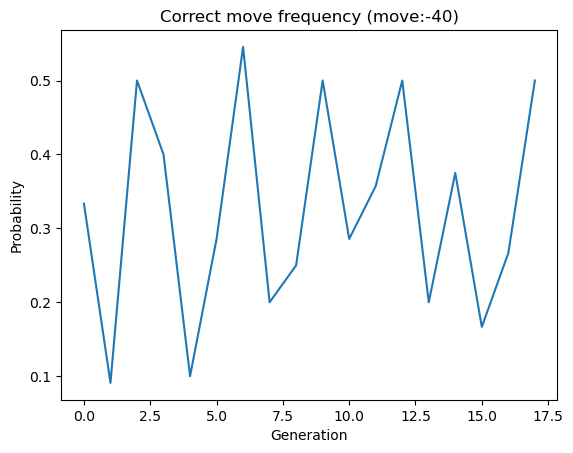

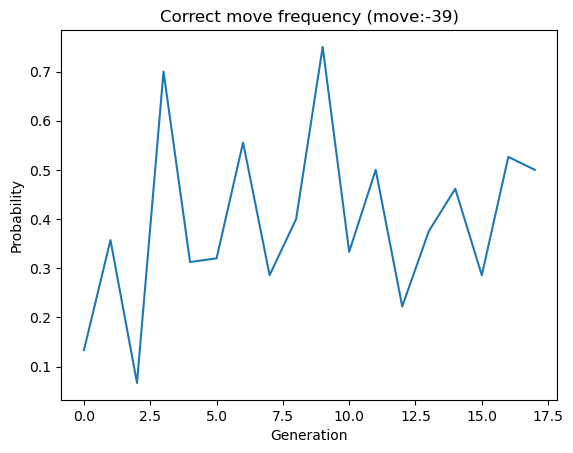

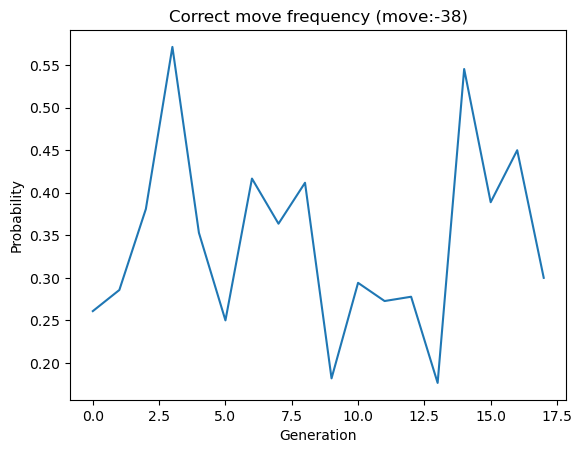

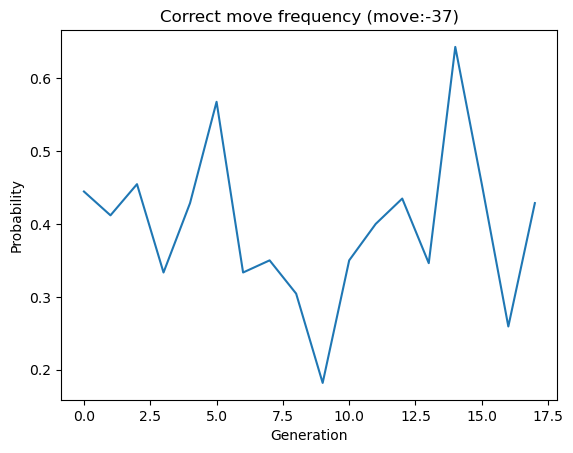

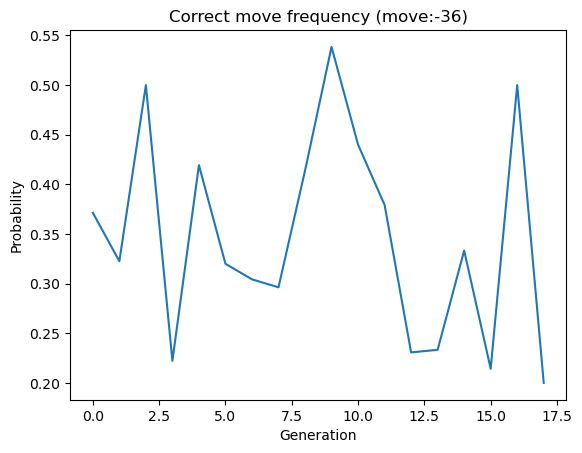

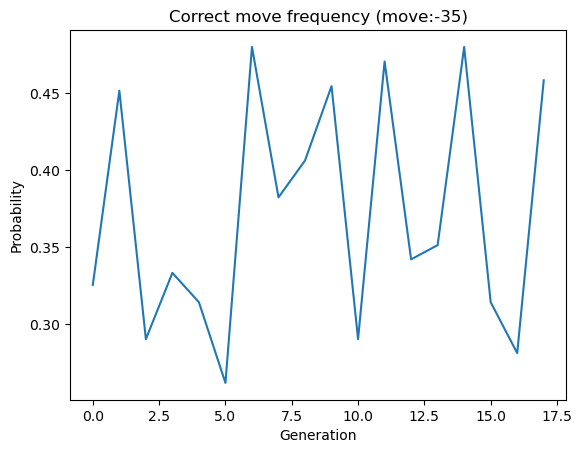

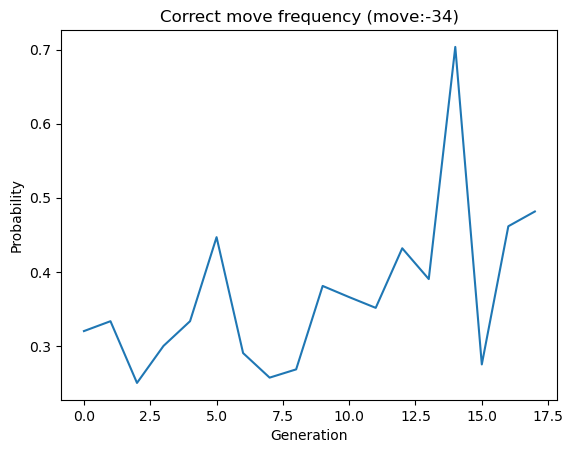

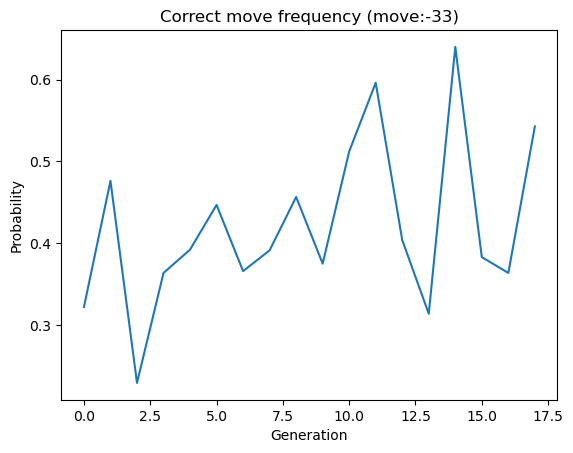

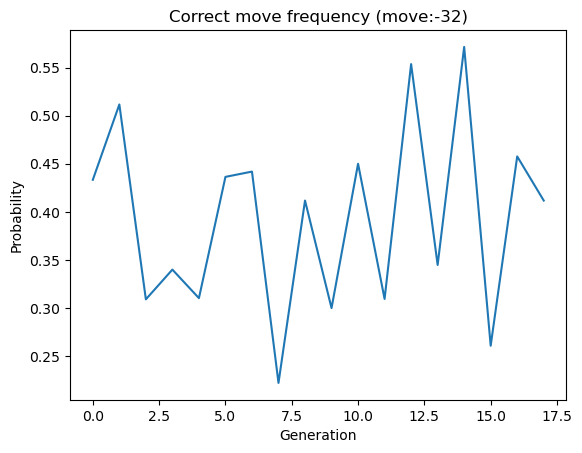

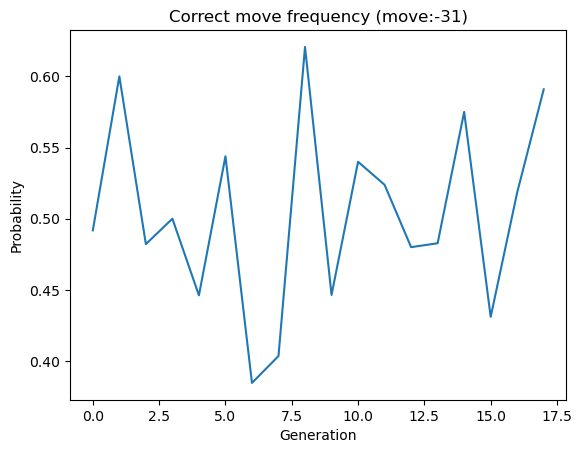

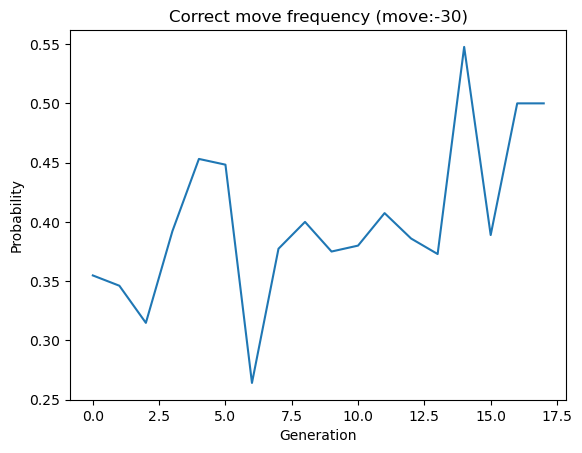

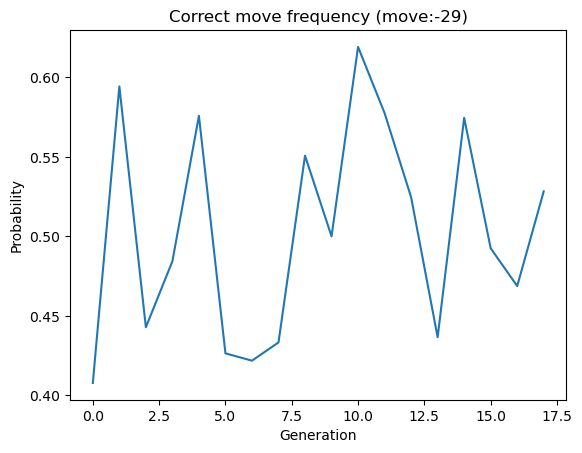

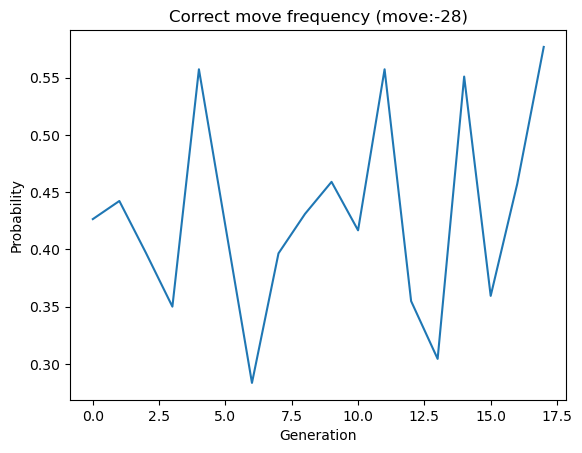

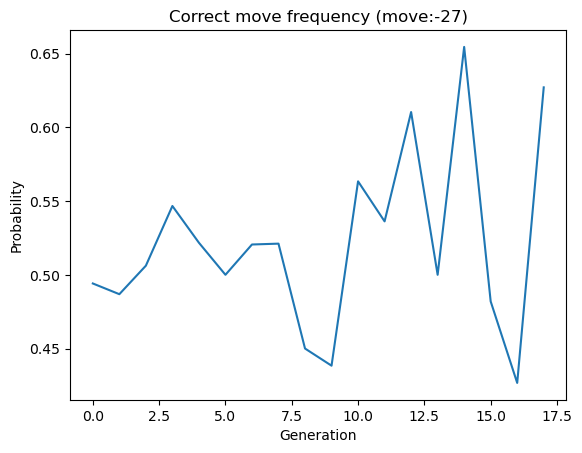

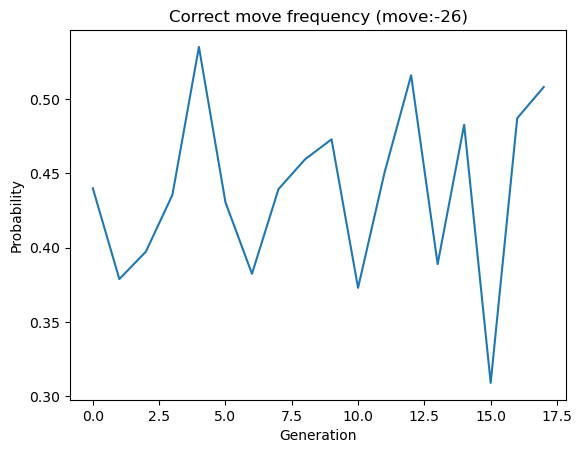

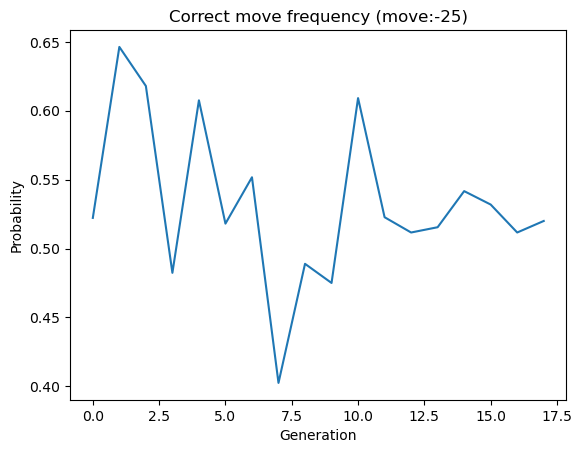

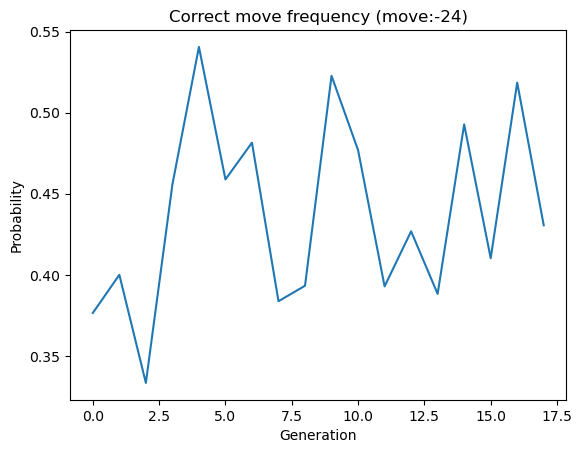

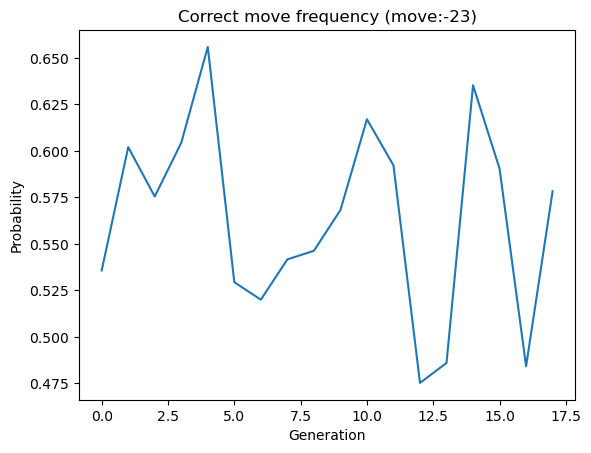

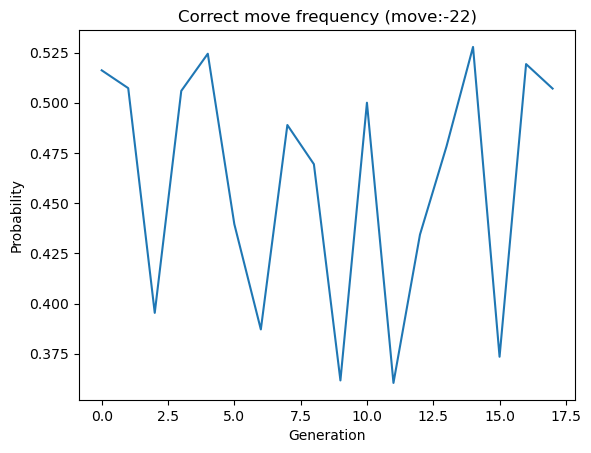

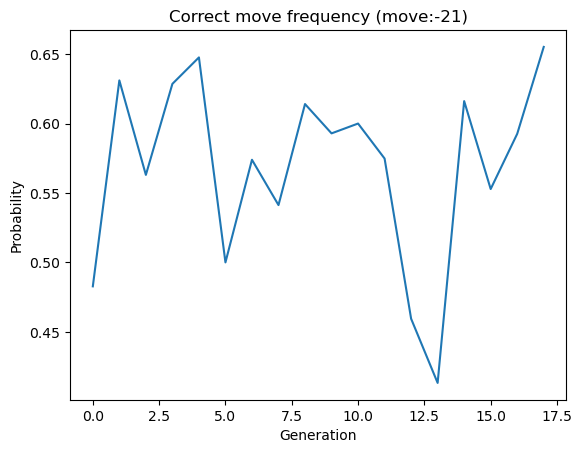

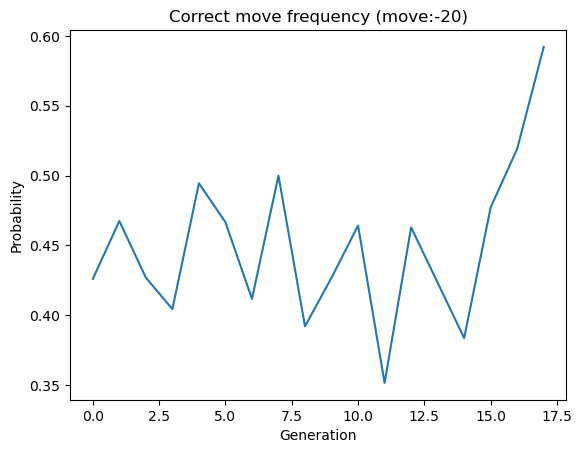

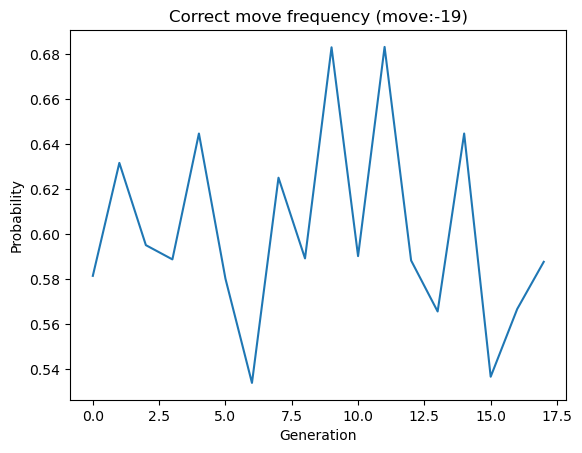

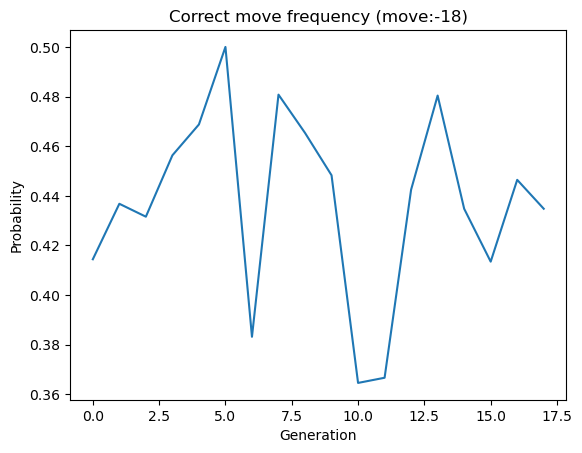

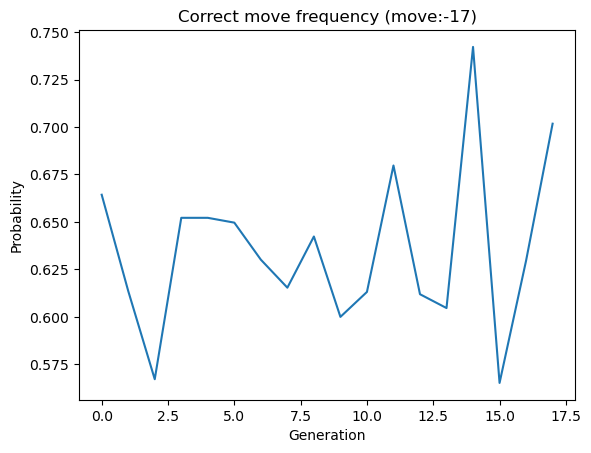

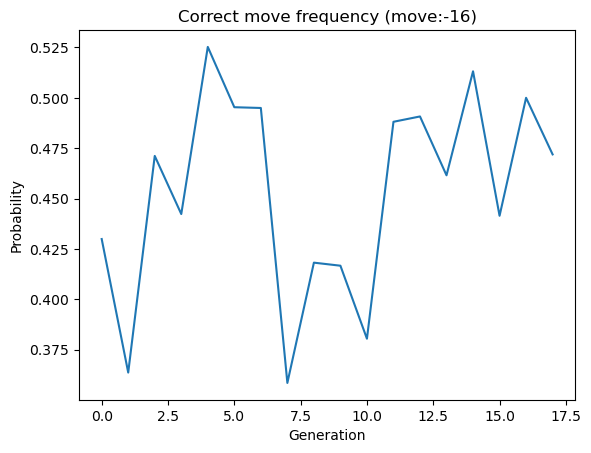

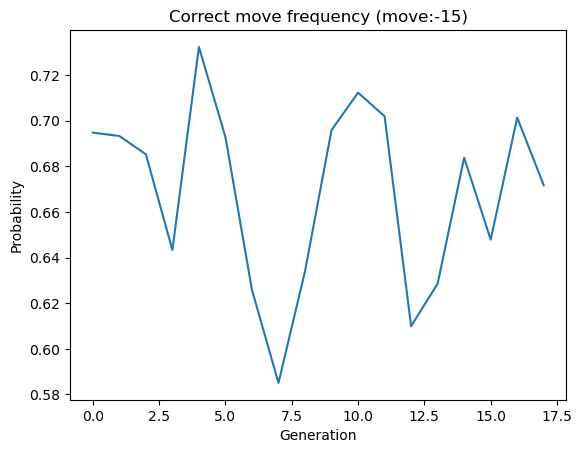

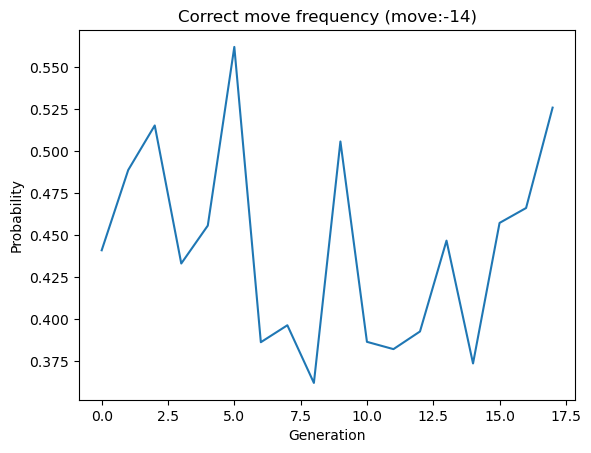

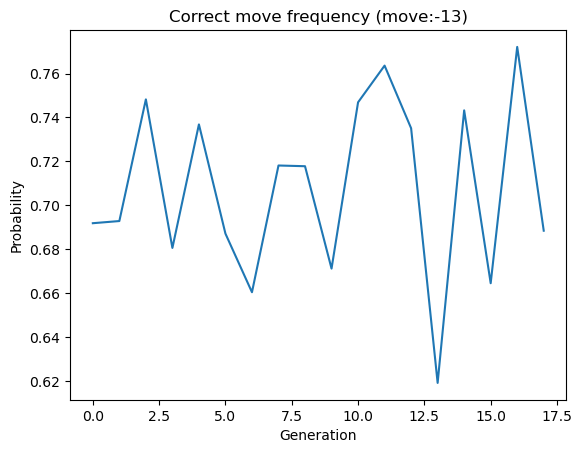

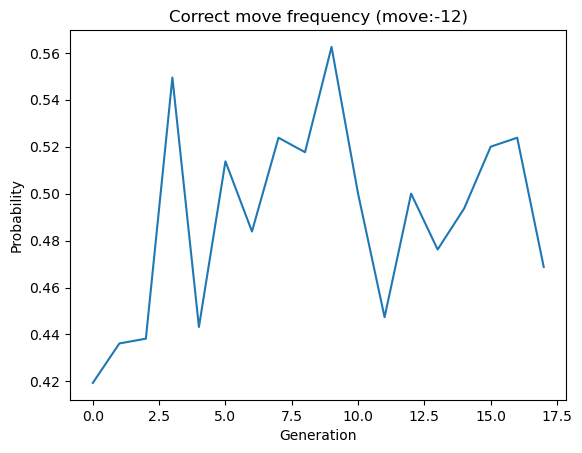

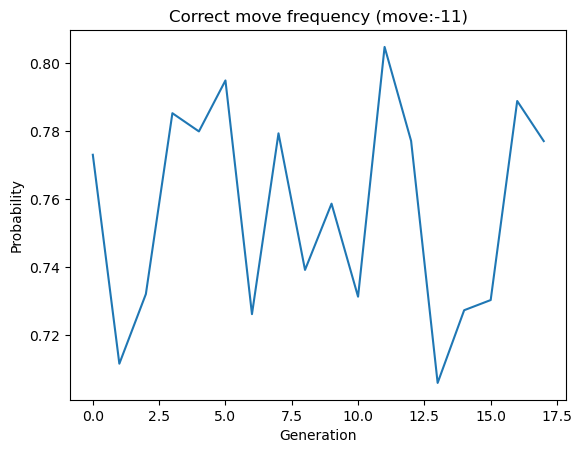

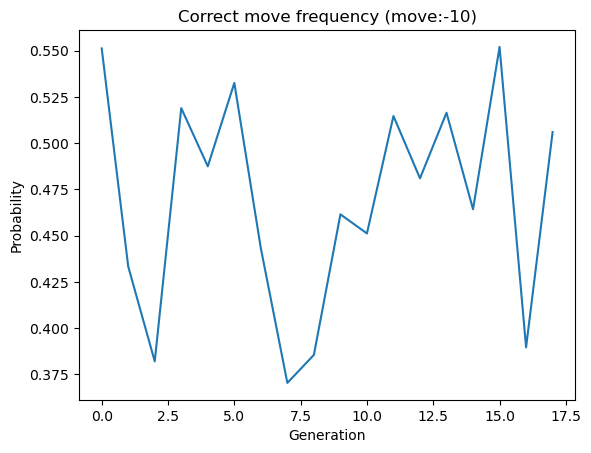

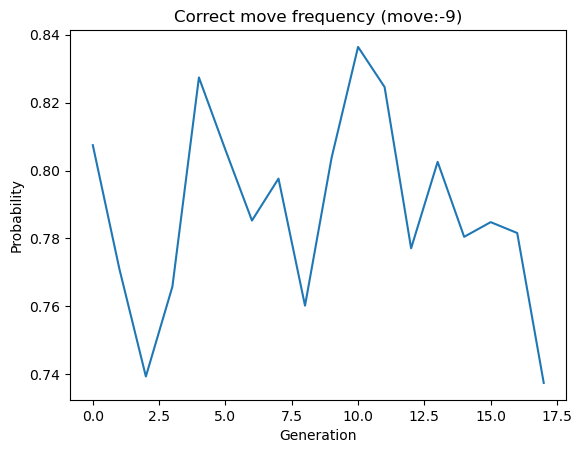

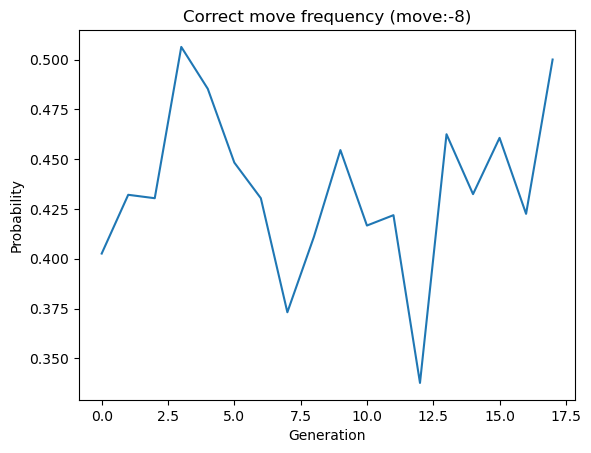

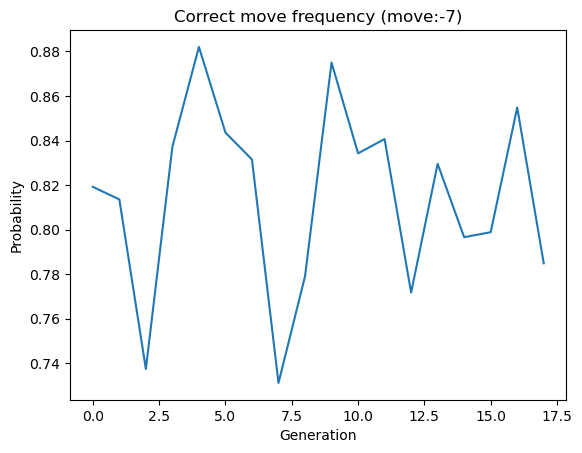

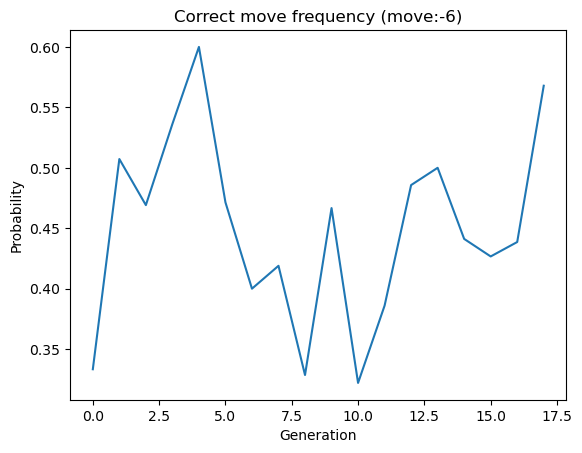

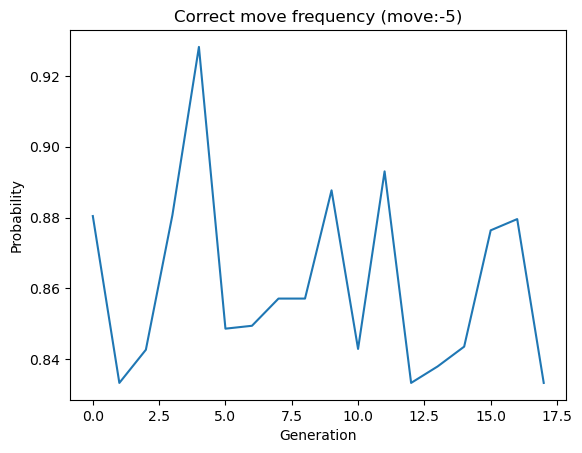

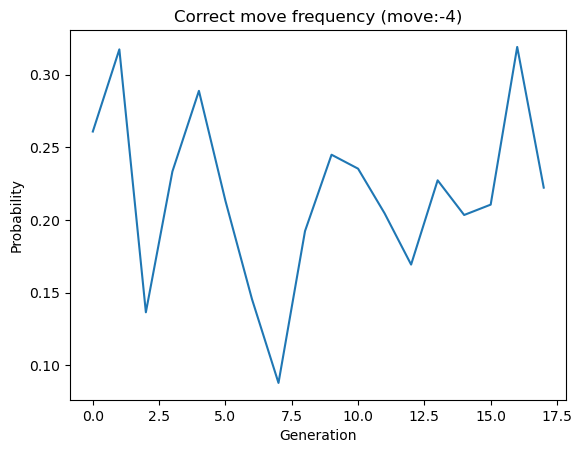

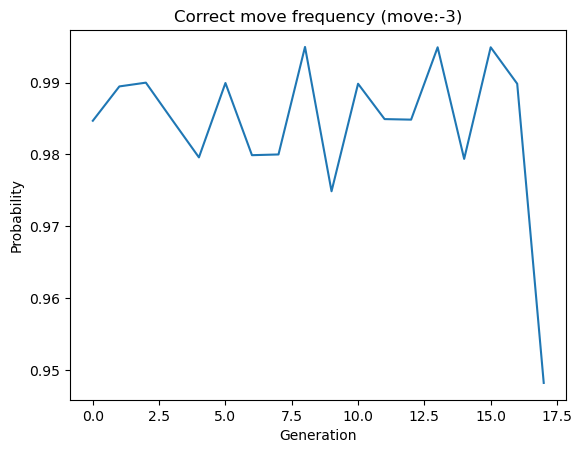

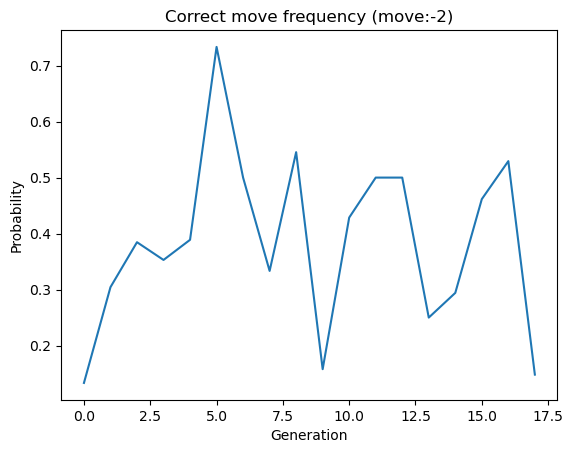

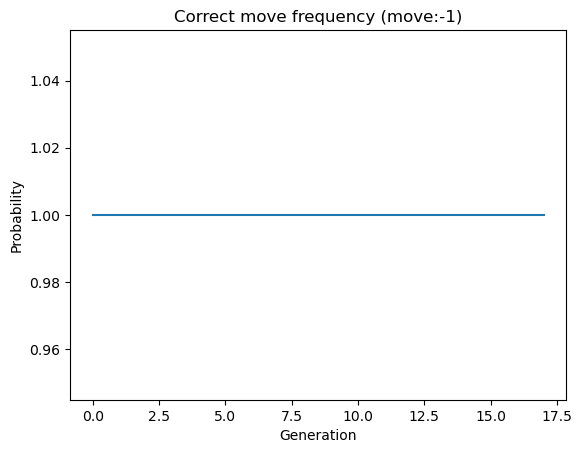

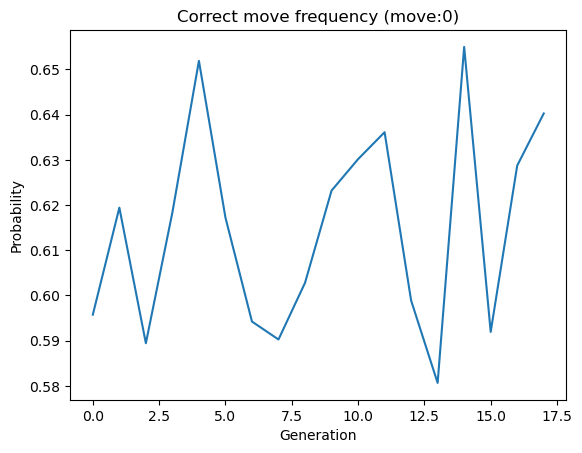

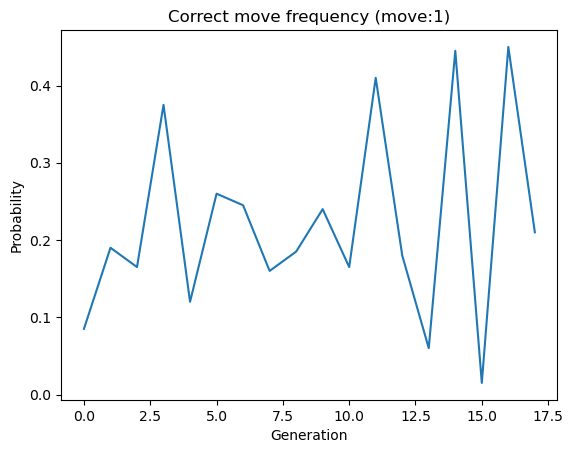

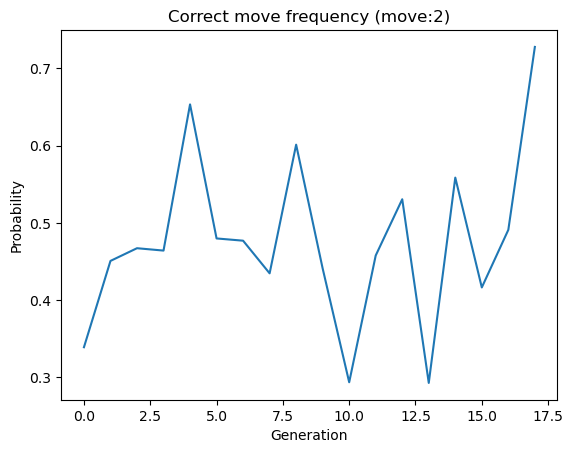

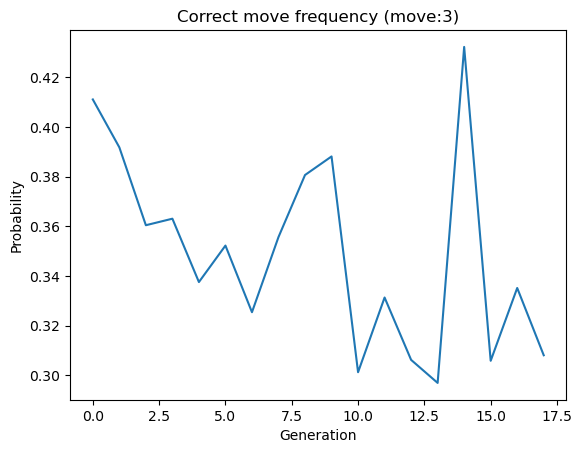

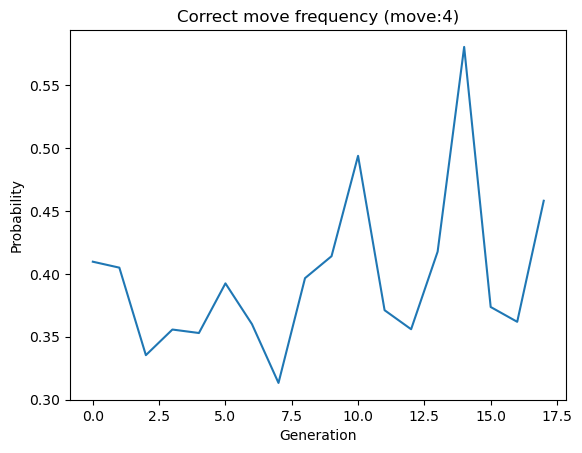

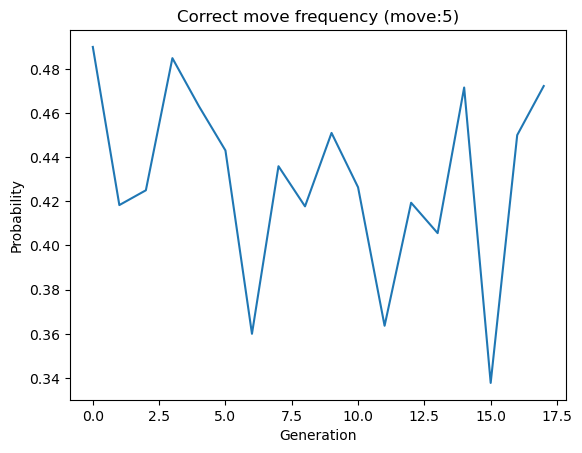

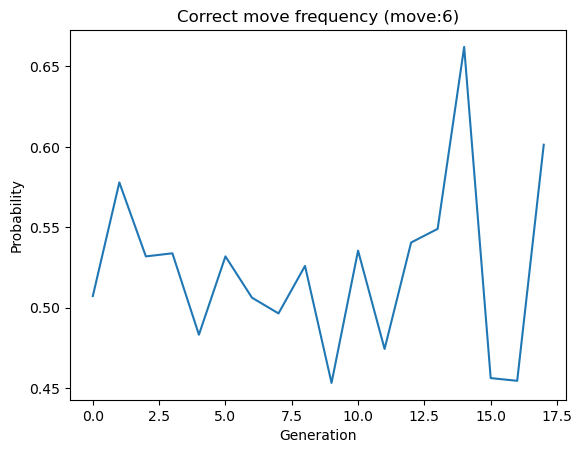

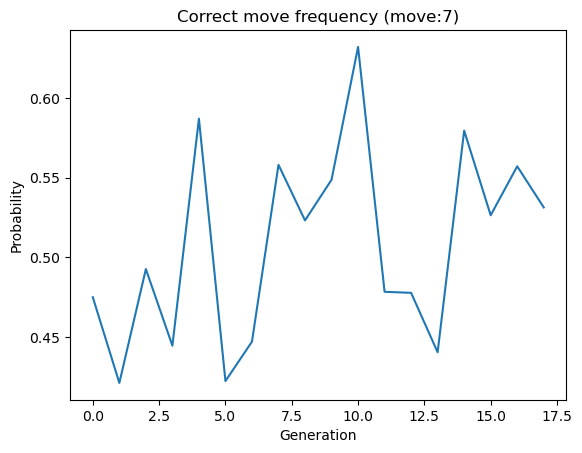

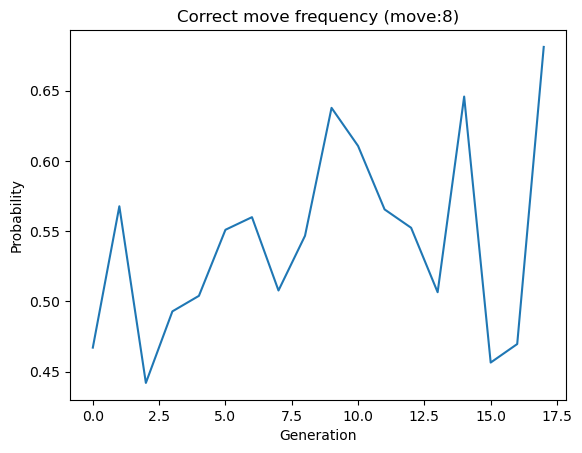

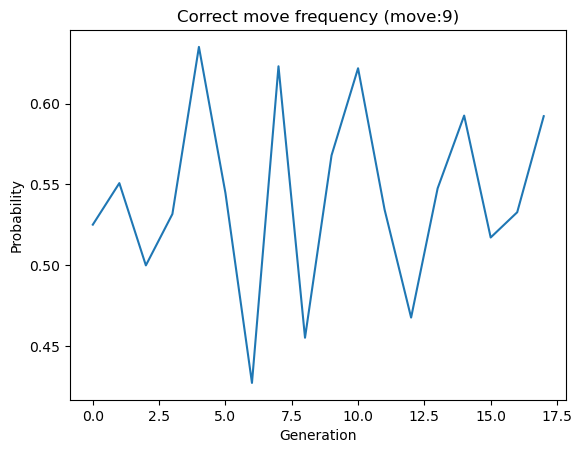

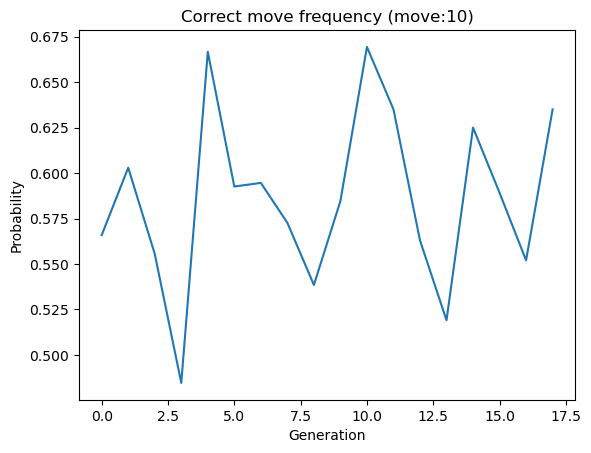

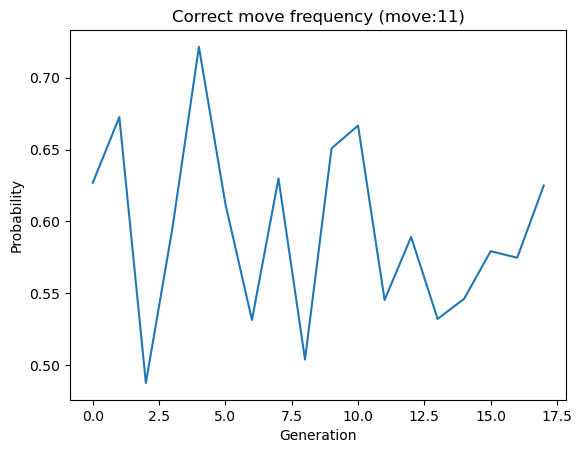

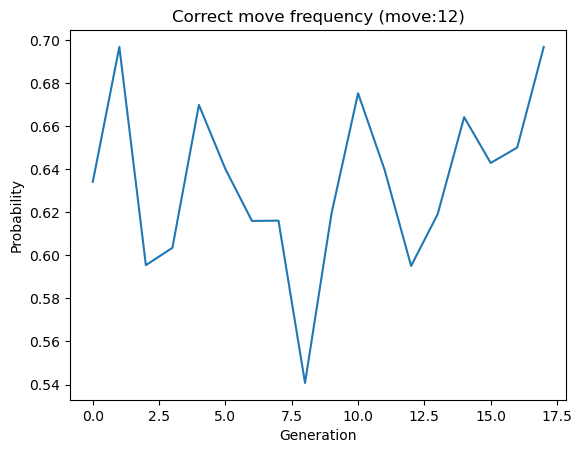

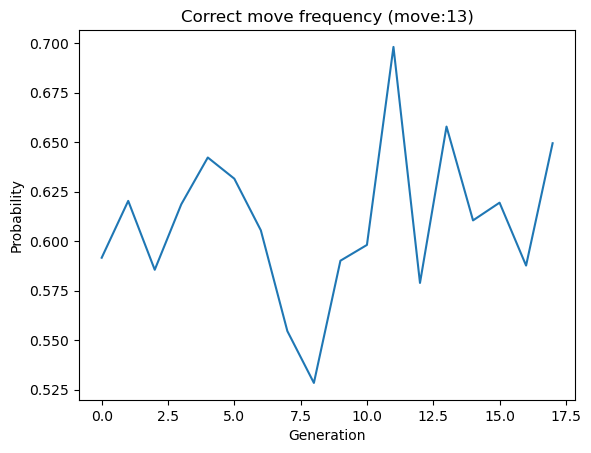

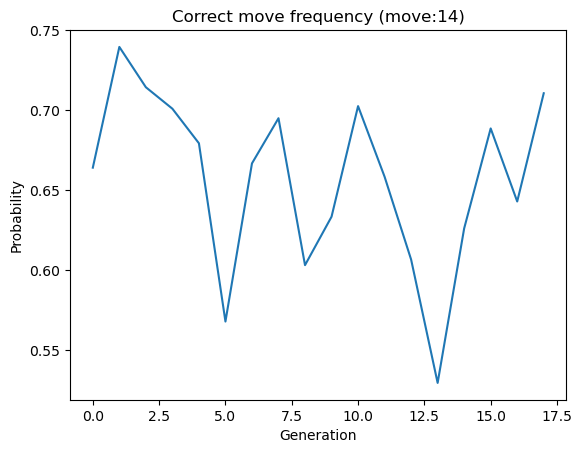

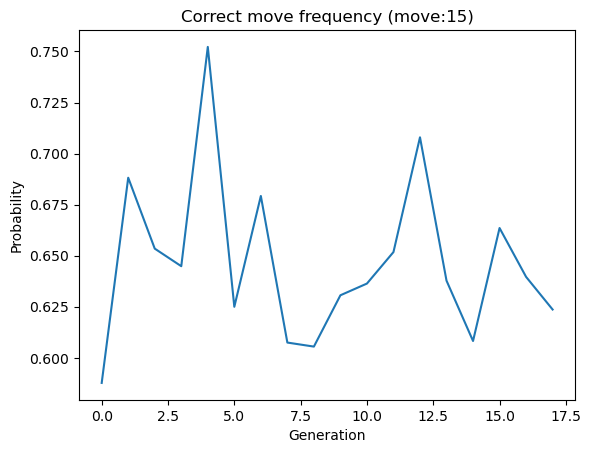

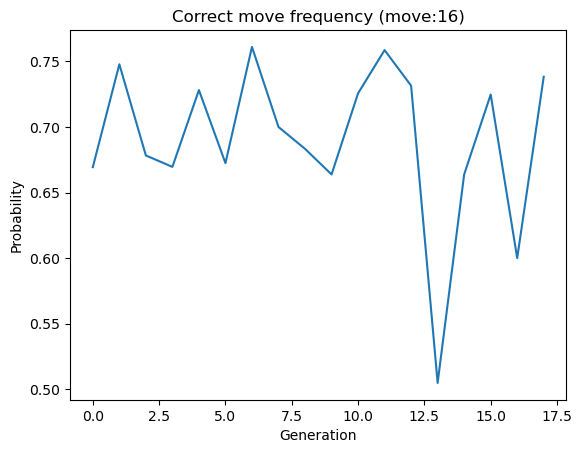

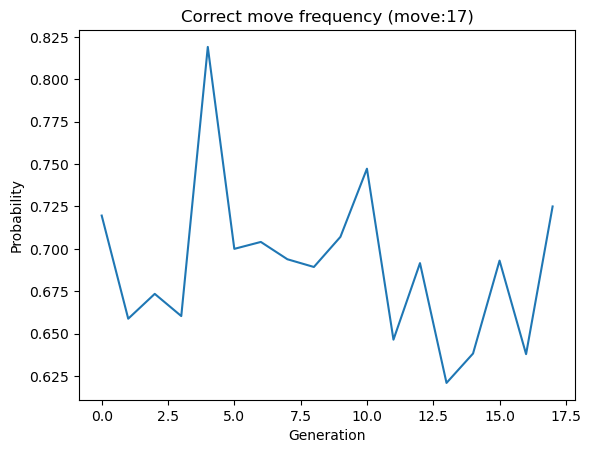

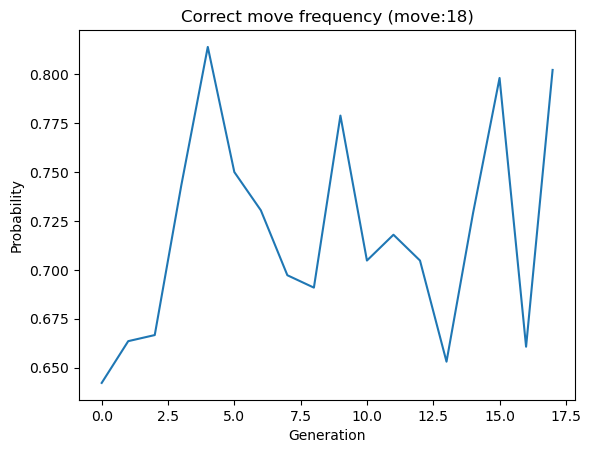

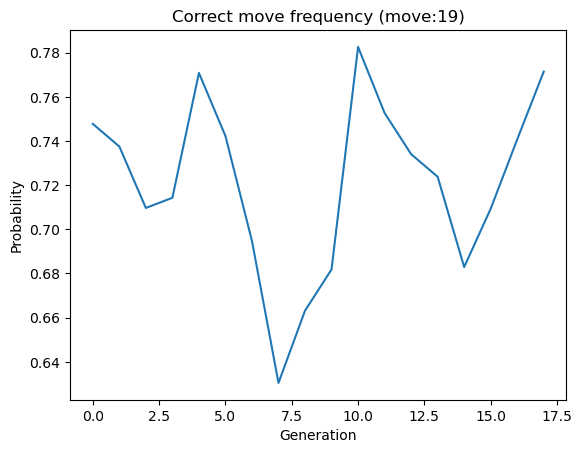

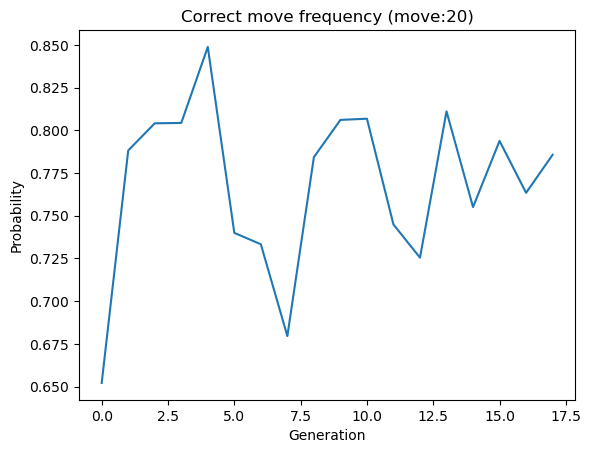

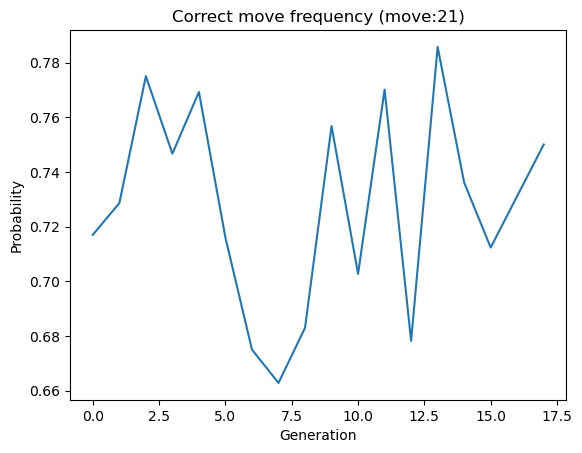

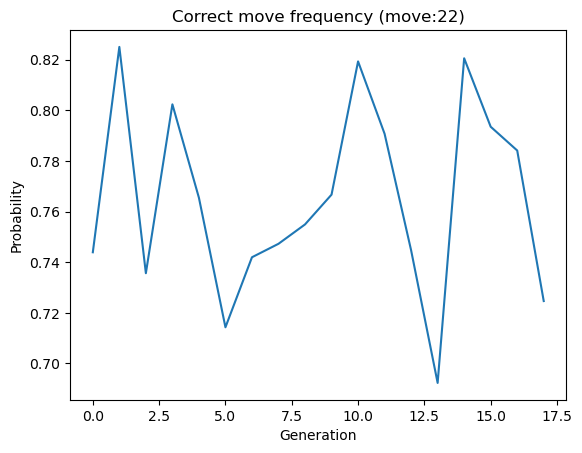

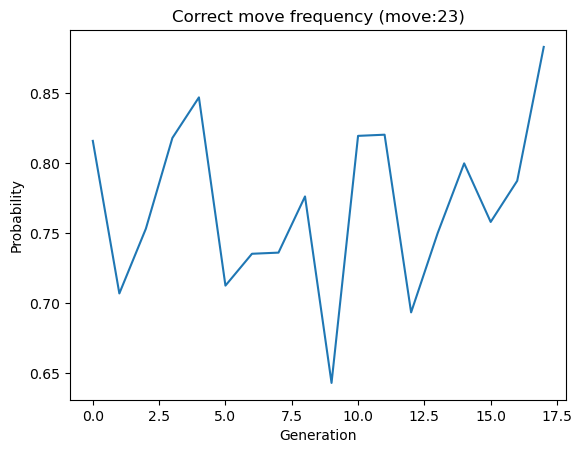

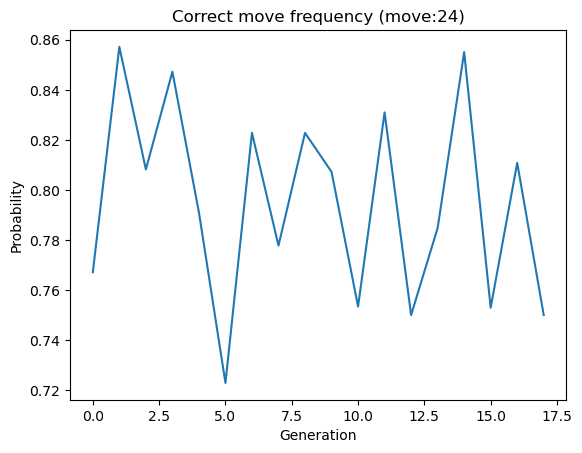

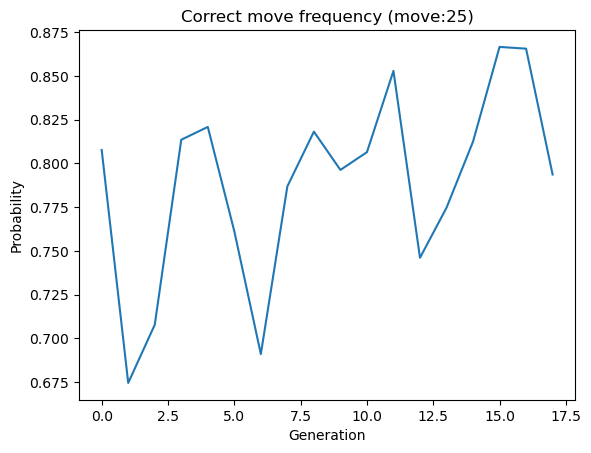

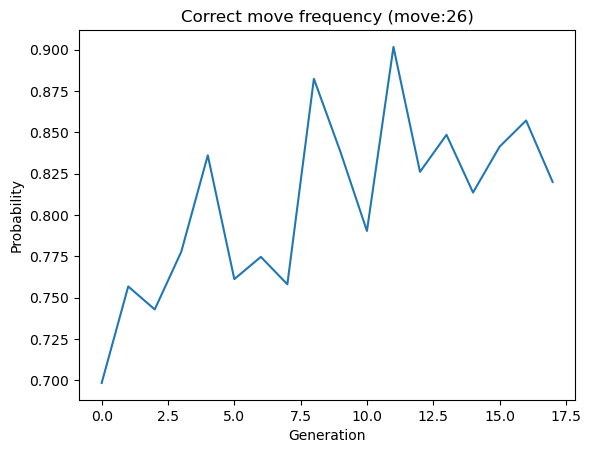

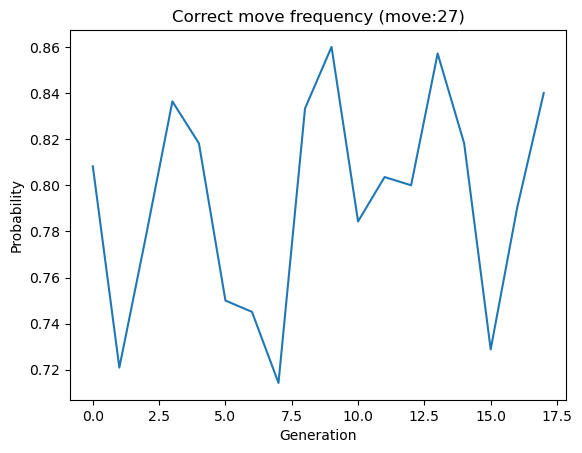

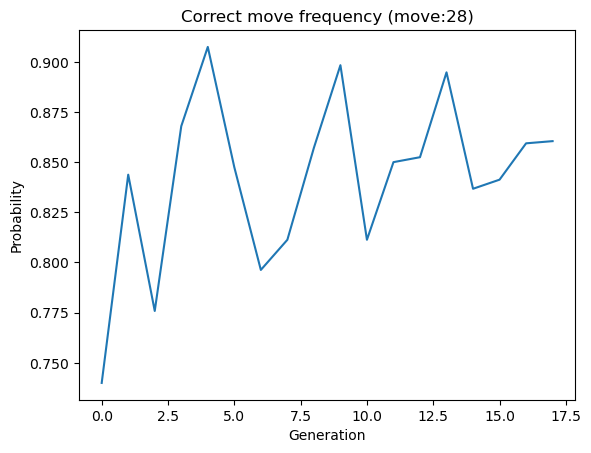

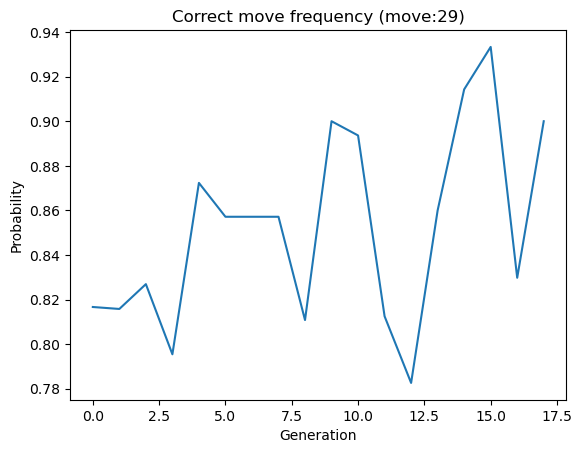

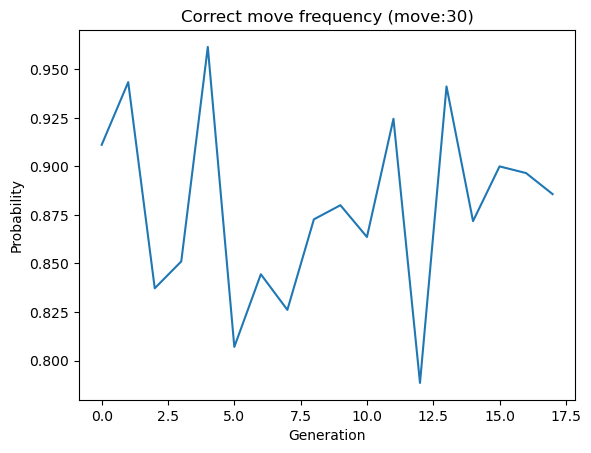

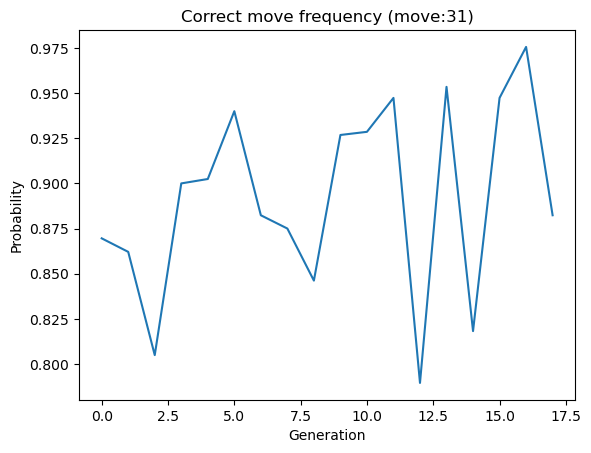

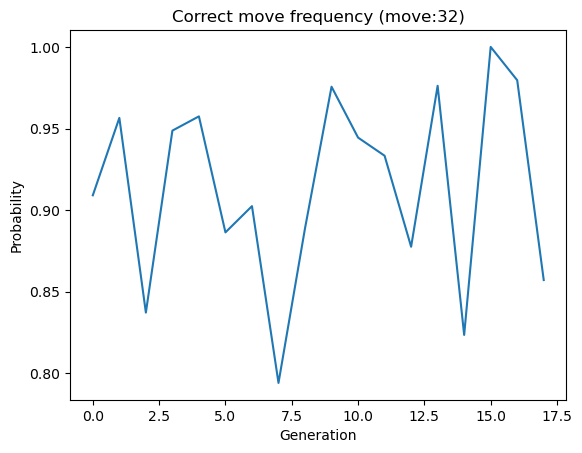

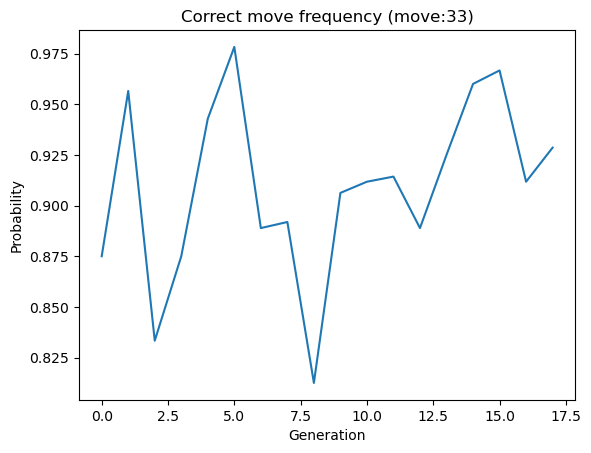

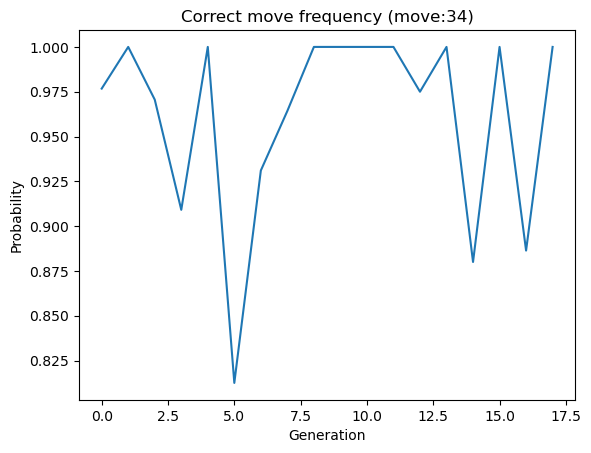

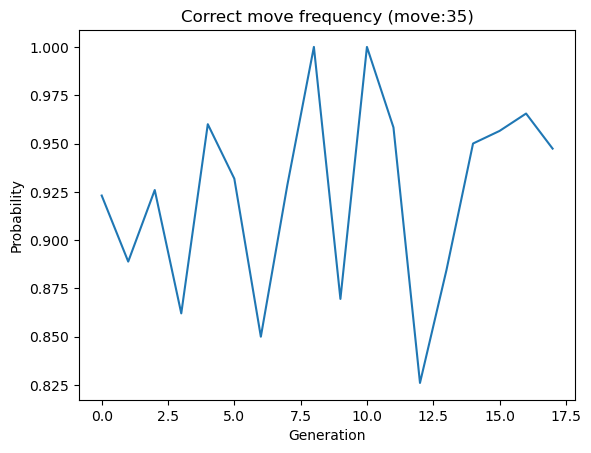

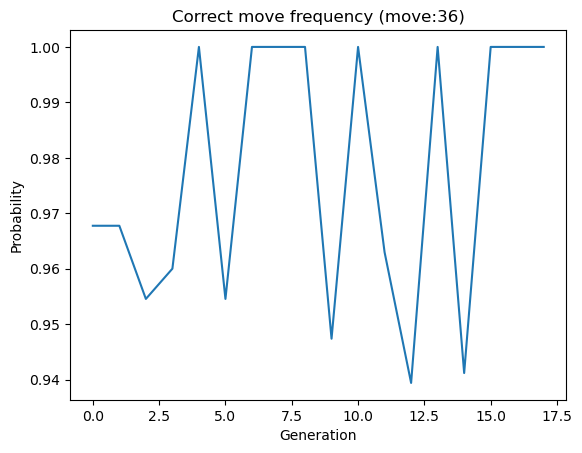

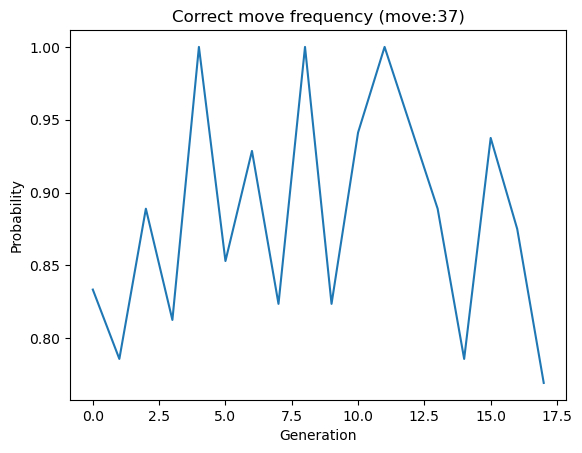

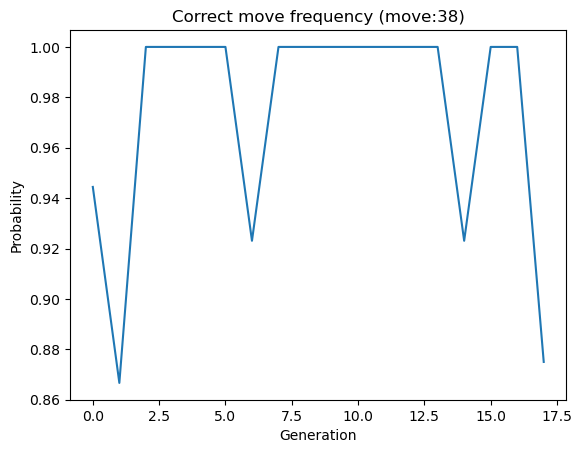

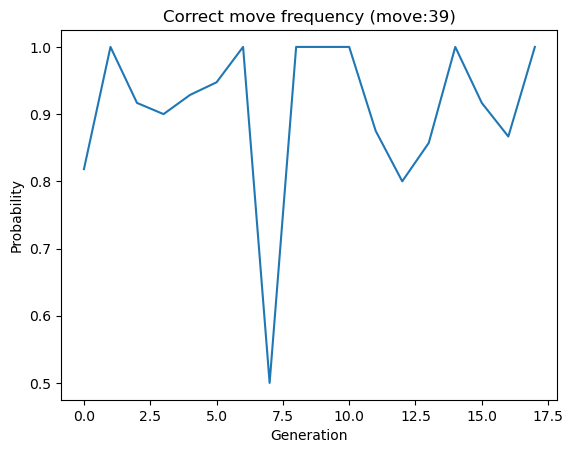

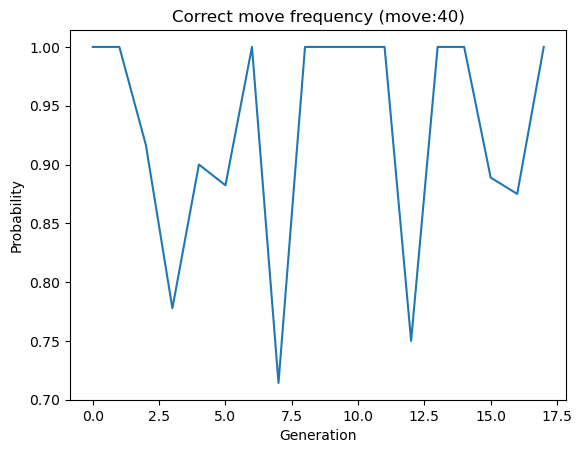

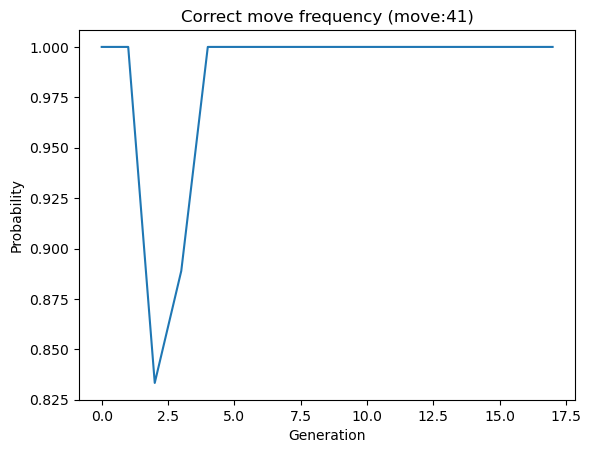

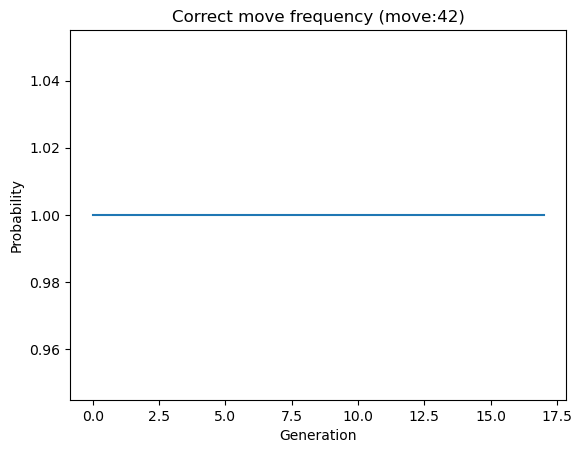

In [253]:
for move in range(-42, 43):
    grader.plot(move)

In [45]:
class ProgressVisualizer:
    def __init__(self, manager_path: str):
        self.manager_path = manager_path
        self.gating_logs_dir = os.path.join(manager_path, 'gating-logs')

        self.max_gen = 0
        self.den = np.zeros((self.max_gen, 42, 22))
        self.baseline = np.zeros((self.max_gen, 42, 22))
        self.net_t0 = np.zeros((self.max_gen, 42, 22))
        self.net_t1 = np.zeros((self.max_gen, 42, 22))
        self.mcts_t0 = np.zeros((self.max_gen, 42, 22))
        self.mcts_t1 = np.zeros((self.max_gen, 42, 22))
        
    def resize(self, gen: int):
        if gen <= self.max_gen:
            return
        
        prev_max_gen = self.max_gen
        self.max_gen = gen
        
        den = np.zeros((self.max_gen, 42, 22))
        baseline = np.zeros((self.max_gen, 42, 22))
        net_t0 = np.zeros((self.max_gen, 42, 22))
        net_t1 = np.zeros((self.max_gen, 42, 22))
        mcts_t0 = np.zeros((self.max_gen, 42, 22))
        mcts_t1 = np.zeros((self.max_gen, 42, 22))
        
        den[:prev_max_gen] = self.den
        baseline[:prev_max_gen] = self.baseline
        net_t0[:prev_max_gen] = self.net_t0
        net_t1[:prev_max_gen] = self.net_t1
        mcts_t0[:prev_max_gen] = self.mcts_t0
        mcts_t1[:prev_max_gen] = self.mcts_t1
        
        self.den = den
        self.baseline = baseline
        self.net_t0 = net_t0
        self.net_t1 = net_t1
        self.mcts_t0 = mcts_t0
        self.mcts_t1 = mcts_t1

    def parse_gating_log(self, gen: int, log_filename: str):
        valid = False
        with open(log_filename, 'r') as f:
            for line in f:
                if line.startswith('OracleGrader done'):
                    valid = True
                    break

        if not valid:
            # log appears to be mid-write
            return
        
        self.resize(gen - 1)
        g = gen - 2
        with open(log_filename, 'r') as f:
            for line in f:
                if not line.startswith('OracleGrader '):
                    continue
                """
                OracleGrader 23-5 count:7 net-t0:0.142857 net-t1:0.139192 mcts-t0:0.142857 mcts-t1:0.128450 baseline:0.177551
                """
                tokens = line.split()
                if tokens[1] == 'overall':
                    continue
                if tokens[1] == 'done':
                    return
                move_num, score = map(int, tokens[1].split('-'))
                d = {}
                for token in tokens[2:]:
                    subtokens = token.split(':')
                    d[subtokens[0]] = float(subtokens[1])

                m = move_num - 1
                s = score
#                 s = (score + 1 ) // 2
                
                self.den[g, m, s] = d['count']
                self.baseline[g, m, s] = d['baseline']
                self.net_t0[g, m, s] = d['net-t0']
                self.net_t1[g, m, s] = d['net-t1']
                self.mcts_t0[g, m, s] = d['mcts-t0']
                self.mcts_t1[g, m, s] = d['mcts-t1']
                
    def refresh(self):
        for filename in natsorted(os.listdir(self.gating_logs_dir)):
            # gen-1-epoch-2.txt
            full_filename = os.path.join(self.gating_logs_dir, filename)
            gen = int(filename.split('-')[1])
            assert gen > 1, filename
            self.parse_gating_log(gen, full_filename)

    def plot(self):
        self.refresh()
        
        from bokeh.layouts import column, row
        from bokeh.models import ColumnDataSource, TextInput, RangeSlider
        from bokeh.plotting import figure, show
        
        move_number = RangeSlider(title='Move-number', start=1, end=42, step=1, value=(1, 42))
        moves_to_win = RangeSlider(title='Moves-to-win', start=1, end=21, step=1, value=(1, 21))
        
        n = self.den.shape[0]
        x = np.arange(n)
        den = self.den.sum(axis=(1, 2))
        
        wb = self.baseline * self.den
        wn0 = self.net_t0 * self.den
        wn1 = self.net_t1 * self.den
        wm0 = self.mcts_t0 * self.den
        wm1 = self.mcts_t1 * self.den
        
        b = wb.sum(axis=(1, 2)) / den
        n0 = wn0.sum(axis=(1, 2)) / den
        n1 = wn1.sum(axis=(1, 2)) / den
        m0 = wm0.sum(axis=(1, 2)) / den
        m1 = wm1.sum(axis=(1, 2)) / den
        
        source = ColumnDataSource(data=dict(x=x, b=b, n0=n0, n1=n1, m0=m0, m1=m1))
        
        plot = figure(title='Mistake Rate', x_range=[x[0], x[-1]], y_range=[0, 1])
        plot.line('x', 'b', source=source, line_color='blue')
        plot.line('x', 'n0', source=source, line_color='green', line_dash='dashed')
        plot.line('x', 'n1', source=source, line_color='green')
        plot.line('x', 'm0', source=source, line_color='red', line_dash='dashed')
        plot.line('x', 'm1', source=source, line_color='red')
        
        def update_data(attrname, old, new):
            mn0 = move_number.start - 1
            mn1 = move_number.end - 1
            mw0 = moves_to_win.start
            mw1 = moves_to_win.end

            den = self.den[:, mn0:mn1, mw0:mw1]
            b = wb[:, mn0:mn1, mw0:mw1].sum(axis=(1, 2)) / den
            n0 = wn0[:, mn0:mn1, mw0:mw1].sum(axis=(1, 2)) / den
            n1 = wn1[:, mn0:mn1, mw0:mw1].sum(axis=(1, 2)) / den
            m0 = wm0[:, mn0:mn1, mw0:mw1].sum(axis=(1, 2)) / den
            m1 = wm1[:, mn0:mn1, mw0:mw1].sum(axis=(1, 2)) / den
            
            source.data = dict(x=x, b=b, n0=n0, n1=n1, m0=m0, m1=m1)

        widgets = [move_number, moves_to_win]        
        for widget in widgets:
            widget.on_change('value', update_data)
        
        inputs = column(plot, move_number, moves_to_win)
        show(inputs)

In [67]:
visualizer = ProgressVisualizer('/media/dshin/c4h')
visualizer.plot()

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [39]:
visualizer.den.shape
visualizer.den[0:2, 4:8, 10:20].shape

(2, 4, 10)

In [56]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

x = np.linspace(0, 2*np.pi, 2000)
y = np.sin(x)

Loading BokehJS ...

In [57]:

p = figure(title="simple line example", height=300, width=600, y_range=(-5,5),
           background_fill_color='#efefef')
r = p.line(x, y, color="#8888cc", line_width=1.5, alpha=0.8)

In [58]:
def update(f, w=1, A=1, phi=0):
    if   f == "sin": func = np.sin
    elif f == "cos": func = np.cos
    r.data_source.data['y'] = A * func(w * x + phi)
    push_notebook()

In [59]:
show(p, notebook_handle=True)

In [63]:
interact(update, f=["sin", "cos"], w=(0,50), A=(1,10), phi=(0, 20, 0.1))

interactive(children=(Dropdown(description='f', options=('sin', 'cos'), value='sin'), IntSlider(value=1, descr…

<function __main__.update(f, w=1, A=1, phi=0)>

In [65]:
interact?

In [66]:
def square(num=1):
    print("{} squared is {}".format(num, num*num))
interact(square, num=5)

5 squared is 25


interactive(children=(IntSlider(value=5, description='num', max=15, min=-5), Output()), _dom_classes=('widget-…

<function __main__.square(num=1)>

In [25]:
t = np.zeros((5,4,3))

In [27]:
t.sum()

0.0

In [64]:
easy_arr = torch.zeros((1,2,7,6))
easy_arr[(0, 1, 3, 0)] = 1

for gen in range(2, 800):
    net = torch.jit.load(f'/media/dshin/c4h/promoted-models/gen-{gen}.ptj')
    t = net(easy_arr)[0]
    s = ' '.join(map(lambda x: '%.3f'%x, map(float, t.softmax(1)[0])))
    print(f'gen-{gen}: {s}')

gen-2: 0.129 0.117 0.184 0.142 0.180 0.114 0.134
gen-3: 0.125 0.102 0.181 0.138 0.196 0.118 0.140
gen-4: 0.112 0.113 0.191 0.137 0.190 0.125 0.132
gen-5: 0.110 0.113 0.195 0.150 0.198 0.113 0.121
gen-6: 0.100 0.111 0.202 0.150 0.194 0.123 0.120
gen-7: 0.105 0.109 0.218 0.148 0.205 0.111 0.104
gen-8: 0.105 0.115 0.223 0.166 0.185 0.111 0.096
gen-9: 0.096 0.107 0.230 0.161 0.204 0.107 0.096
gen-10: 0.094 0.103 0.237 0.163 0.212 0.104 0.087
gen-11: 0.087 0.104 0.235 0.165 0.216 0.104 0.089
gen-12: 0.087 0.108 0.219 0.175 0.218 0.102 0.091
gen-13: 0.084 0.106 0.222 0.181 0.226 0.093 0.087
gen-14: 0.073 0.102 0.218 0.175 0.242 0.101 0.089
gen-15: 0.077 0.100 0.219 0.177 0.248 0.095 0.086
gen-16: 0.066 0.088 0.245 0.188 0.230 0.107 0.076
gen-17: 0.066 0.086 0.235 0.196 0.252 0.093 0.072
gen-18: 0.065 0.087 0.228 0.211 0.248 0.092 0.069
gen-19: 0.060 0.086 0.240 0.212 0.242 0.095 0.065
gen-20: 0.059 0.078 0.265 0.217 0.223 0.097 0.061
gen-21: 0.056 0.083 0.224 0.243 0.242 0.089 0.063
gen-22: 

gen-166: 0.045 0.026 0.414 0.023 0.422 0.029 0.040
gen-167: 0.045 0.026 0.418 0.023 0.417 0.029 0.041
gen-168: 0.043 0.027 0.416 0.023 0.424 0.028 0.039
gen-169: 0.044 0.025 0.435 0.023 0.409 0.027 0.038
gen-170: 0.043 0.024 0.433 0.023 0.412 0.027 0.038
gen-171: 0.040 0.022 0.434 0.023 0.417 0.026 0.037
gen-172: 0.042 0.019 0.434 0.021 0.420 0.026 0.039
gen-173: 0.041 0.020 0.438 0.022 0.417 0.023 0.040
gen-174: 0.042 0.018 0.437 0.023 0.418 0.022 0.040
gen-175: 0.045 0.020 0.431 0.026 0.415 0.022 0.041
gen-176: 0.043 0.019 0.433 0.028 0.414 0.021 0.041
gen-177: 0.043 0.020 0.428 0.027 0.416 0.022 0.043
gen-178: 0.044 0.020 0.430 0.027 0.415 0.022 0.043
gen-179: 0.043 0.020 0.433 0.029 0.412 0.021 0.042
gen-180: 0.044 0.019 0.424 0.027 0.421 0.021 0.044
gen-181: 0.043 0.018 0.407 0.027 0.443 0.021 0.042
gen-182: 0.046 0.020 0.418 0.030 0.420 0.023 0.044
gen-183: 0.046 0.020 0.419 0.029 0.418 0.023 0.045
gen-184: 0.046 0.020 0.414 0.029 0.426 0.022 0.043
gen-185: 0.046 0.020 0.411 0.02

gen-327: 0.018 0.008 0.466 0.009 0.471 0.009 0.019
gen-328: 0.018 0.008 0.476 0.009 0.460 0.009 0.020
gen-329: 0.017 0.008 0.478 0.009 0.461 0.009 0.019
gen-330: 0.017 0.008 0.482 0.008 0.459 0.009 0.018
gen-331: 0.017 0.007 0.486 0.008 0.455 0.008 0.018
gen-332: 0.018 0.008 0.470 0.008 0.470 0.009 0.018
gen-333: 0.018 0.008 0.464 0.009 0.476 0.009 0.018
gen-334: 0.018 0.008 0.463 0.008 0.476 0.009 0.018
gen-335: 0.016 0.007 0.481 0.008 0.461 0.009 0.018
gen-336: 0.017 0.007 0.472 0.008 0.469 0.009 0.018
gen-337: 0.017 0.007 0.482 0.008 0.460 0.009 0.018
gen-338: 0.017 0.008 0.471 0.008 0.470 0.008 0.018
gen-339: 0.017 0.007 0.476 0.008 0.467 0.008 0.017
gen-340: 0.017 0.007 0.480 0.008 0.464 0.008 0.017
gen-341: 0.017 0.008 0.469 0.008 0.472 0.008 0.018
gen-342: 0.018 0.008 0.466 0.008 0.474 0.008 0.018
gen-343: 0.017 0.007 0.472 0.008 0.469 0.008 0.018
gen-344: 0.017 0.007 0.484 0.008 0.457 0.009 0.018
gen-345: 0.017 0.007 0.480 0.008 0.463 0.008 0.017
gen-346: 0.017 0.008 0.477 0.00

gen-490: 0.017 0.007 0.479 0.007 0.466 0.008 0.017
gen-491: 0.016 0.007 0.481 0.006 0.466 0.007 0.016
gen-492: 0.016 0.007 0.476 0.007 0.469 0.008 0.017
gen-493: 0.017 0.007 0.476 0.007 0.469 0.008 0.017
gen-494: 0.017 0.007 0.472 0.006 0.474 0.007 0.016
gen-495: 0.016 0.007 0.474 0.007 0.471 0.008 0.016
gen-496: 0.017 0.008 0.468 0.007 0.476 0.008 0.017
gen-497: 0.016 0.007 0.471 0.006 0.475 0.008 0.016
gen-498: 0.017 0.007 0.473 0.007 0.473 0.008 0.016
gen-499: 0.017 0.008 0.469 0.008 0.472 0.009 0.018
gen-500: 0.017 0.007 0.471 0.007 0.475 0.007 0.016
gen-501: 0.017 0.007 0.464 0.007 0.478 0.008 0.017
gen-502: 0.017 0.007 0.471 0.007 0.473 0.008 0.017
gen-503: 0.017 0.007 0.474 0.007 0.471 0.008 0.017
gen-504: 0.016 0.007 0.477 0.007 0.469 0.008 0.016
gen-505: 0.016 0.007 0.476 0.006 0.471 0.007 0.016
gen-506: 0.016 0.007 0.471 0.007 0.474 0.008 0.017
gen-507: 0.016 0.007 0.482 0.007 0.464 0.008 0.016
gen-508: 0.016 0.007 0.468 0.007 0.478 0.008 0.016
gen-509: 0.016 0.007 0.470 0.00

gen-652: 0.017 0.007 0.472 0.006 0.474 0.007 0.016
gen-653: 0.017 0.007 0.470 0.007 0.474 0.008 0.017
gen-654: 0.017 0.007 0.468 0.006 0.478 0.008 0.017
gen-655: 0.017 0.007 0.474 0.006 0.472 0.007 0.017
gen-656: 0.017 0.007 0.475 0.007 0.471 0.007 0.017
gen-657: 0.017 0.007 0.478 0.006 0.469 0.007 0.016
gen-658: 0.017 0.007 0.479 0.007 0.465 0.008 0.016
gen-659: 0.017 0.007 0.479 0.007 0.467 0.007 0.016
gen-660: 0.017 0.007 0.475 0.006 0.472 0.007 0.016
gen-661: 0.016 0.007 0.475 0.007 0.471 0.007 0.016
gen-662: 0.016 0.007 0.470 0.007 0.476 0.007 0.017
gen-663: 0.017 0.007 0.474 0.007 0.472 0.007 0.016
gen-664: 0.017 0.008 0.474 0.007 0.471 0.008 0.017
gen-665: 0.016 0.007 0.480 0.007 0.466 0.008 0.017
gen-666: 0.016 0.007 0.477 0.007 0.469 0.008 0.016
gen-667: 0.016 0.007 0.471 0.007 0.476 0.008 0.016
gen-668: 0.016 0.007 0.473 0.006 0.475 0.007 0.016
gen-669: 0.016 0.007 0.483 0.007 0.463 0.008 0.016
gen-670: 0.016 0.007 0.472 0.007 0.474 0.007 0.017
gen-671: 0.016 0.007 0.486 0.00

In [8]:
net(blank_arr)

(tensor([[-2.3586, -2.3814, -3.2071, -3.7715,  2.2235, -5.6106, -5.2183]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0971,  0.0363]], grad_fn=<AddmmBackward0>))

In [58]:
print(' '.join(map(lambda x: '%.3f'%x, map(float, net(blank_arr)[0].softmax(1)[0]))))

0.081 0.143 0.091 0.177 0.440 0.034 0.034


In [24]:
float(t.softmax(1)[0, 0])

0.46668583154678345

In [22]:
t[0][0]

tensor(-0.0971, grad_fn=<SelectBackward0>)